In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
cd drive/MyDrive/Kevin

/content/drive/.shortcut-targets-by-id/138Sr42Ksl5jXWhYhirol-FDKcwV_de9v/Kevin


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler


In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

### Load the Data* and Make Transformations

*Data Source: U.S. Census Bureau and U.S. Department of Housing and Urban Development, New One Family Houses Sold: United States HSN1F, 
retrieved from FRED, Federal Reserve Bank of St. Louis; 
https://fred.stlouisfed.org/series/HSN1F, March 3

In [2]:

scaler = MinMaxScaler()


In [4]:
y = pd.read_csv('../data/Y.csv', index_col=1)
y.head(2)

,Sales
Date,
2015-07-31,5263
2015-07-30,5020


In [5]:
scaler.fit(y.Sales.values.reshape([-1, 1]))
SalesScaled = scaler.transform(y.Sales.values.reshape(-1, 1))
y['SalesScaled'] = SalesScaled
y.tail(10)

,Sales,SalesScaled
Date,,
2013-01-12,4497,0.107240
2013-01-11,5142,0.122780
2013-01-10,5007,0.119528
2013-01-09,4649,0.110902
2013-01-08,5243,0.125214
2013-01-07,6905,0.165257
2013-01-05,4771,0.113842
2013-01-04,4540,0.108276
2013-01-03,4297,0.102421


### Descriptive Statistics and Visualizations of the Data.

In [6]:
y.describe()

,Sales,SalesScaled
count,844338.000000,844338.000000
mean,6955.959134,0.166485
std,3103.815515,0.074782
min,46.000000,0.000000
25%,4859.000000,0.115962
50%,6369.000000,0.152343
75%,8360.000000,0.200313
max,41551.000000,1.000000


In [8]:
y.head(100)

,Sales,SalesScaled
Date,,
2015-07-31,5263,0.125696
2015-07-30,5020,0.119841
2015-07-29,4782,0.114107
2015-07-28,5011,0.119624
2015-07-27,6102,0.145910
...,...,...
2015-04-07,4163,0.099193
2015-04-04,6709,0.160535
2015-04-02,6574,0.157282


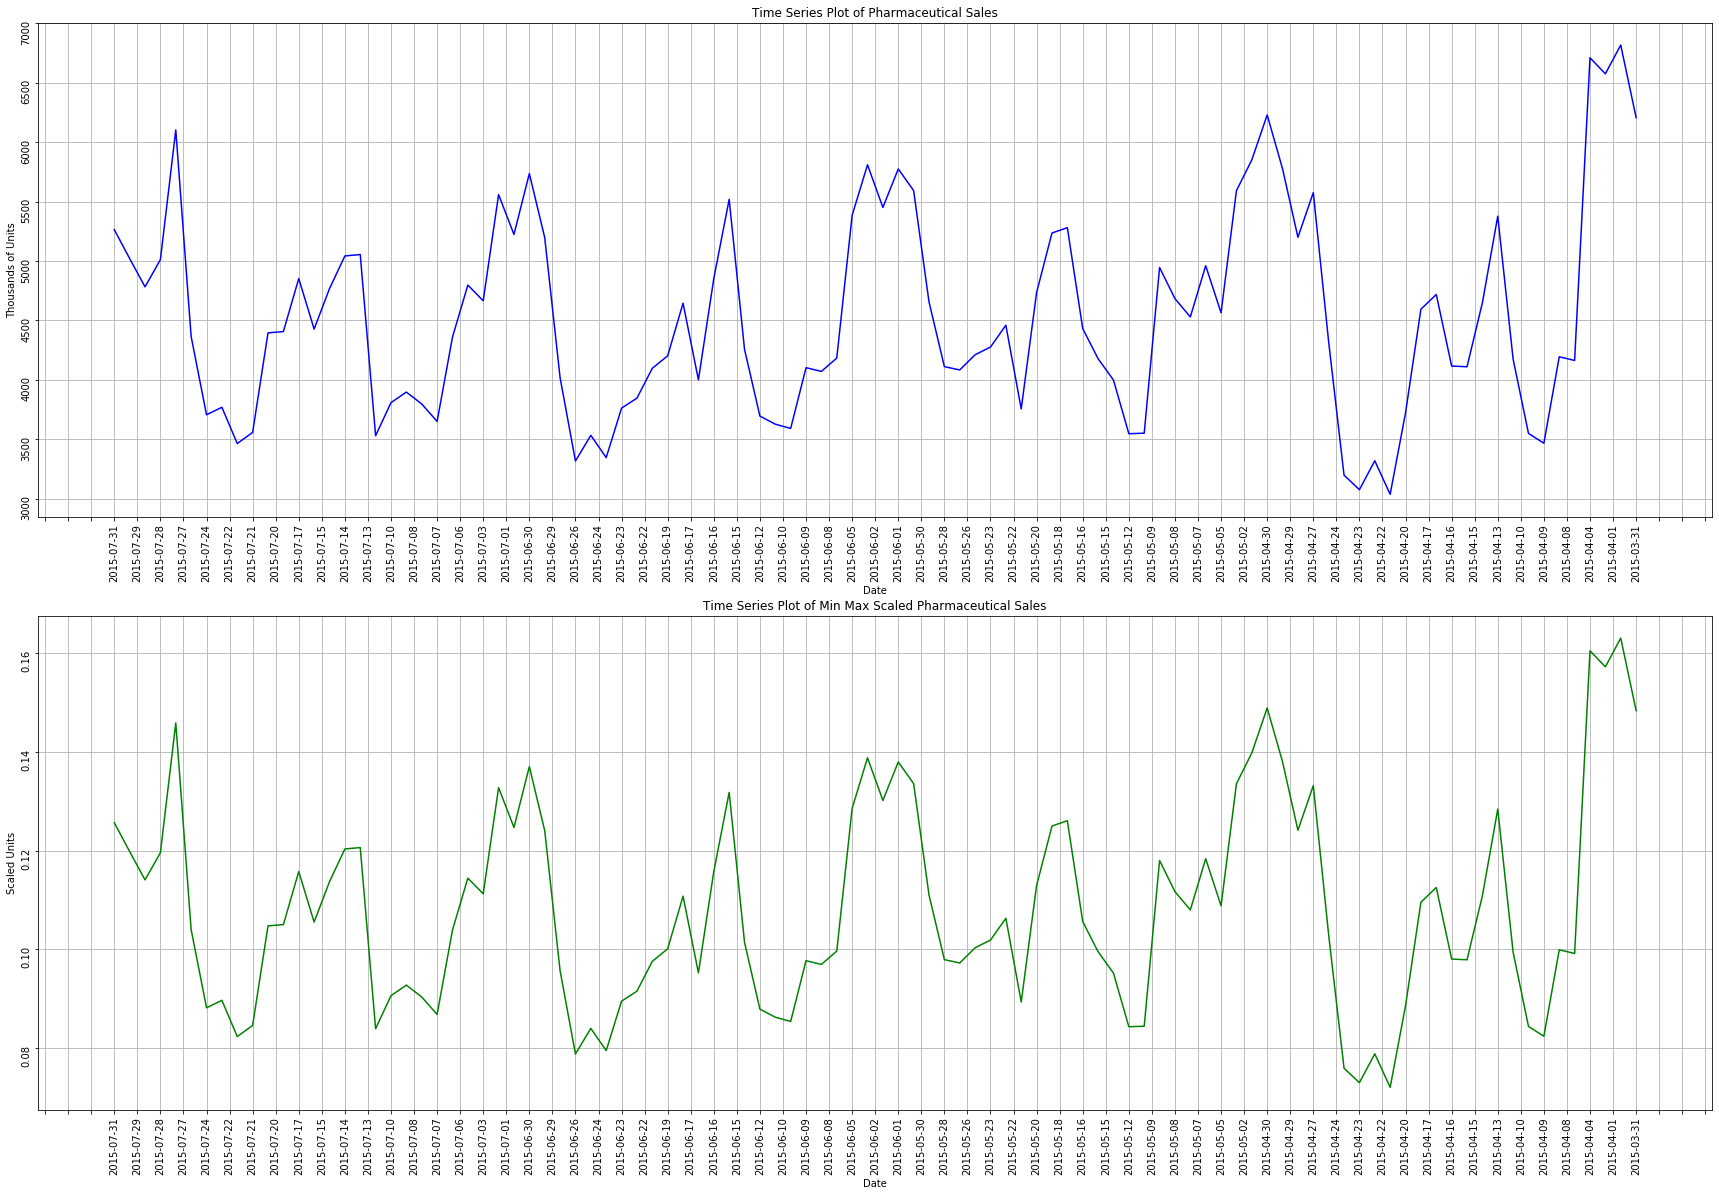

In [9]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(y.head(100).index, y.head(100).Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of Pharmaceutical Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(y.head(100).index, y.head(100).SalesScaled, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series Plot of Min Max Scaled Pharmaceutical Sales')
ax2.grid(True)
plt.show()

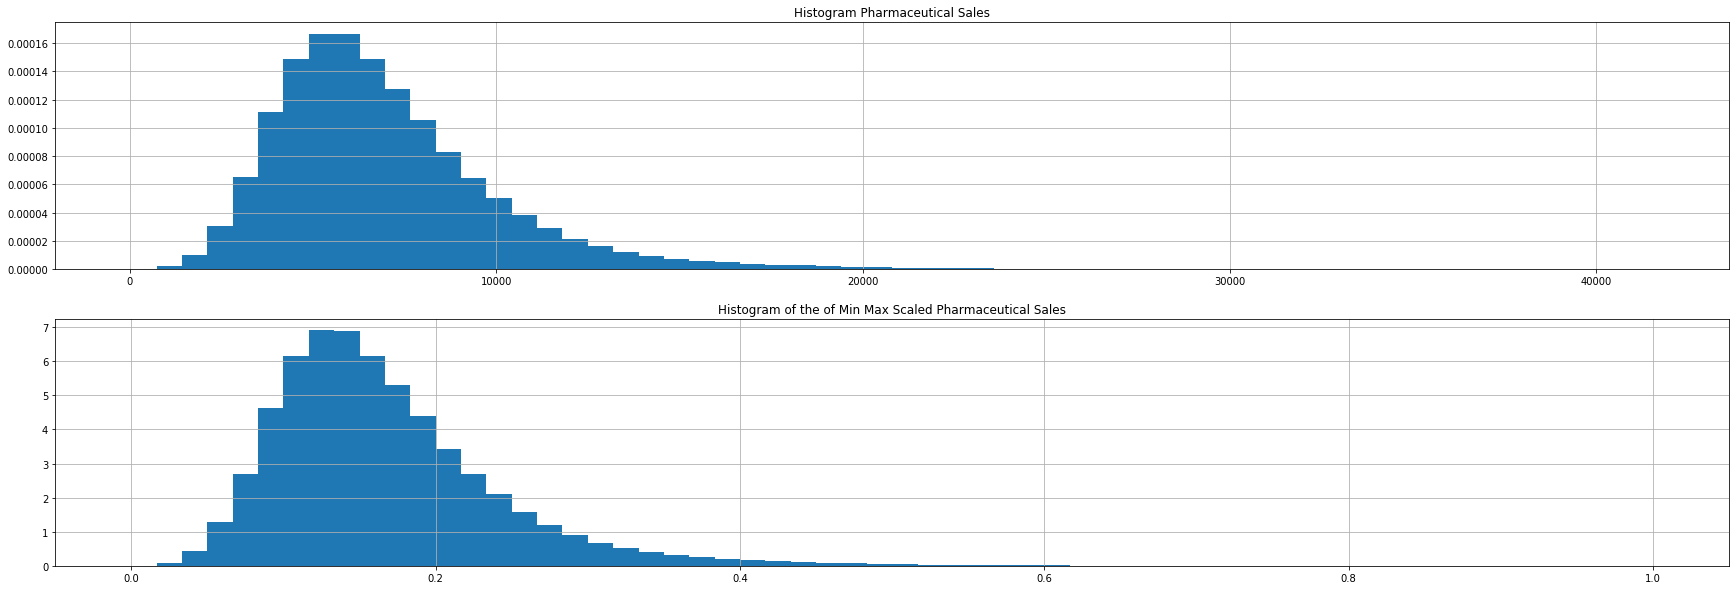

In [10]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(y.Sales, density=True, bins=60)
ax1.title.set_text('Histogram Pharmaceutical Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.hist(y.SalesScaled, density=True, bins=60)
ax2.title.set_text('Histogram of the of Min Max Scaled Pharmaceutical Sales')
ax2.grid(True)
plt.show()

### Unit Root Tests.

Unit Root Tests helps us determine the stationarity of our data

In [11]:
adfResult = adfuller(y.Sales.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

KeyboardInterrupt: 

In [ ]:
adfResult = adfuller(y.SalesScaled.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

#### Removing Stationarity

The trend can be removed from the observations, then added back to forecasts later to return the prediction to the original scale and calculate a comparable error score.

A standard way to remove a trend is by differencing the data. That is the observation from the previous time step (t-1) is subtracted from the current observation (t). This removes the trend and we are left with a difference series, or the changes to the observations from one time step to the next.

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [ ]:
houseSalesDif = difference(houseSales.HouseSalesScaled.values)

In [ ]:
houseSalesDif

0     -0.113494
1     -0.002681
2      0.128686
3     -0.016979
4     -0.053619
         ...   
691   -0.010724
692    0.000000
693   -0.112601
694    0.041108
695    0.033959
Length: 696, dtype: float64

### Autocorrelations and Partial Autocorrelations Plots.

We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

In [12]:
acfSalesScaled = acf(y.SalesScaled.values, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)

In [13]:
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(f"{prefix}  Autocorrelations of Pharmaceutical Sales Min Max Scaled")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()

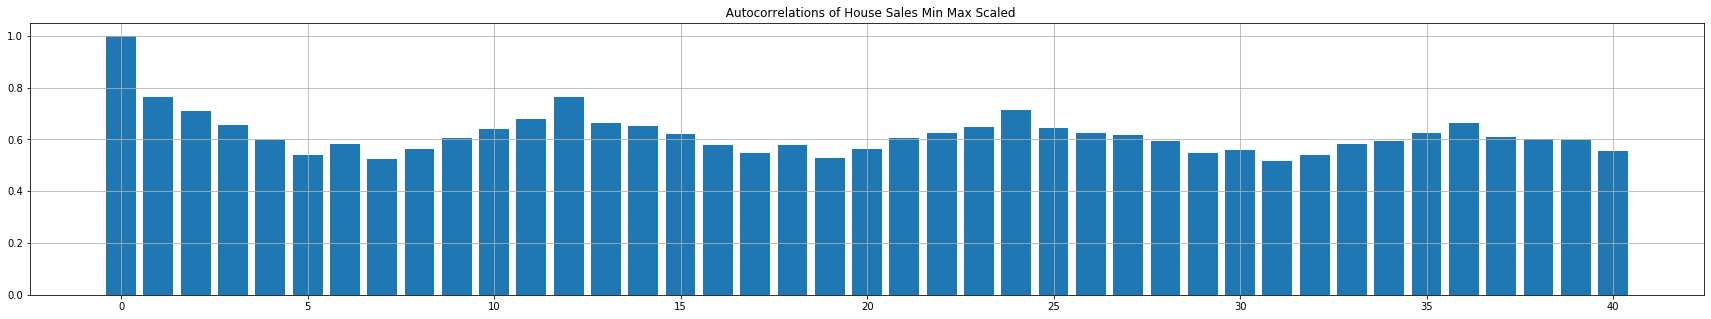

In [14]:
corrPlots(acfSalesScaledNp, '')

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed

In [15]:
pacfSalesScaled = pacf(y.SalesScaled.values, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)

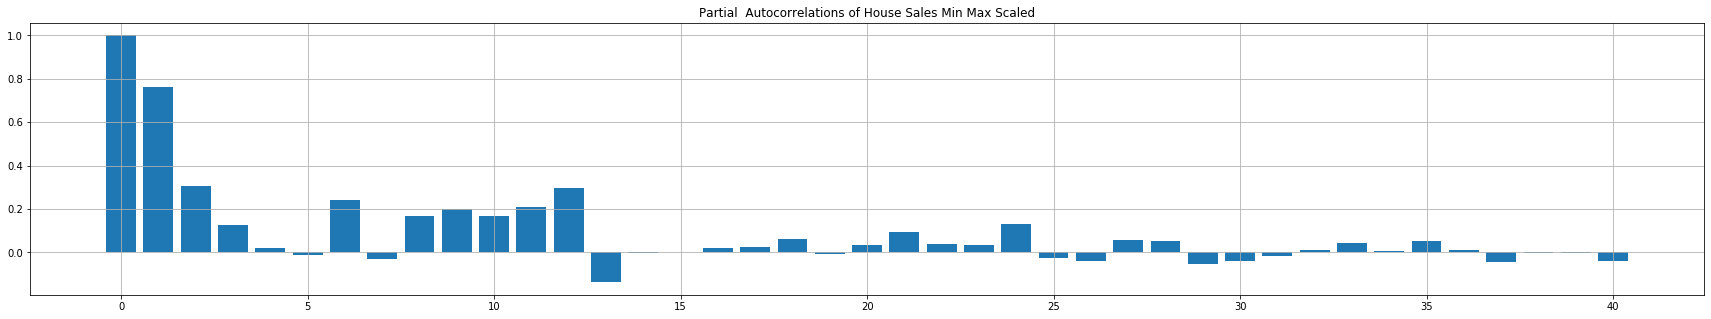

In [16]:
corrPlots(pacfSalesScaledNp, "Partial")

### Separating into a Training and Validation Set Fomat to Use Feed into LSTM.

In [17]:
SIZE = len(y.SalesScaled)
WINDOW_SIZE = 48
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 200

In [18]:
DateTrain = y.index.values[0:BATCH_SIZE]
DateValid = y.index.values[BATCH_SIZE:]
XTrain = y.SalesScaled.values[0:BATCH_SIZE].astype('float32')
XValid = y.SalesScaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (844242, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (844242,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [21]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([844242, 1])

In [22]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset shapes: (1,), types: tf.float32>

In [23]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True) 

In [24]:
# Example of Window
datasetEx = tf.data.Dataset.from_tensor_slices(tf.range(10))
datasetEx = datasetEx.window(5, shift=1, drop_remainder=True)
for window in datasetEx:
    print([elem.numpy() for elem in window])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]


In [25]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

The window() method returns a dataset containing windows, where each window is itself represented as a dataset. Something like {{1,2,3,4,5},{6,7,8,9,10},...}, where {...} represents a dataset. But we just want a regular dataset containing tensors: {[1,2,3,4,5],[6,7,8,9,10],...}, where [...] represents a tensor. The flat_map() method returns all the tensors in a nested dataset, after transforming each nested dataset. If we didn't batch, we would get: {1,2,3,4,5,6,7,8,9,10,...}. By batching each window to its full size, we get {[1,2,3,4,5],[6,7,8,9,10],...}

In [26]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

In [27]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [28]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE): 
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [29]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

### Define and Estimate the LSTM.

In [30]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')

The Huber loss is chosen because it is quite robust for non linear regression models and models with non normal errors.

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 8)           320       
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

Epoch 1/200


KeyboardInterrupt: 

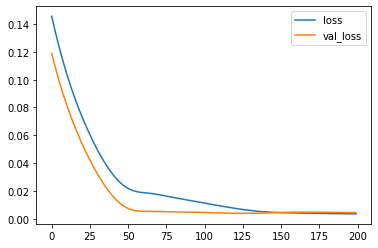

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

### Forecast the LSTM on the Validation Set and Assess Accuracy.

In [ ]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True) 
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [ ]:
Forecast = model_forecast(model, houseSales.HouseSalesScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

A state is: Where am I now inside a sequence? Which time step is it? How is this particular sequence behaving since its beginning up to now?

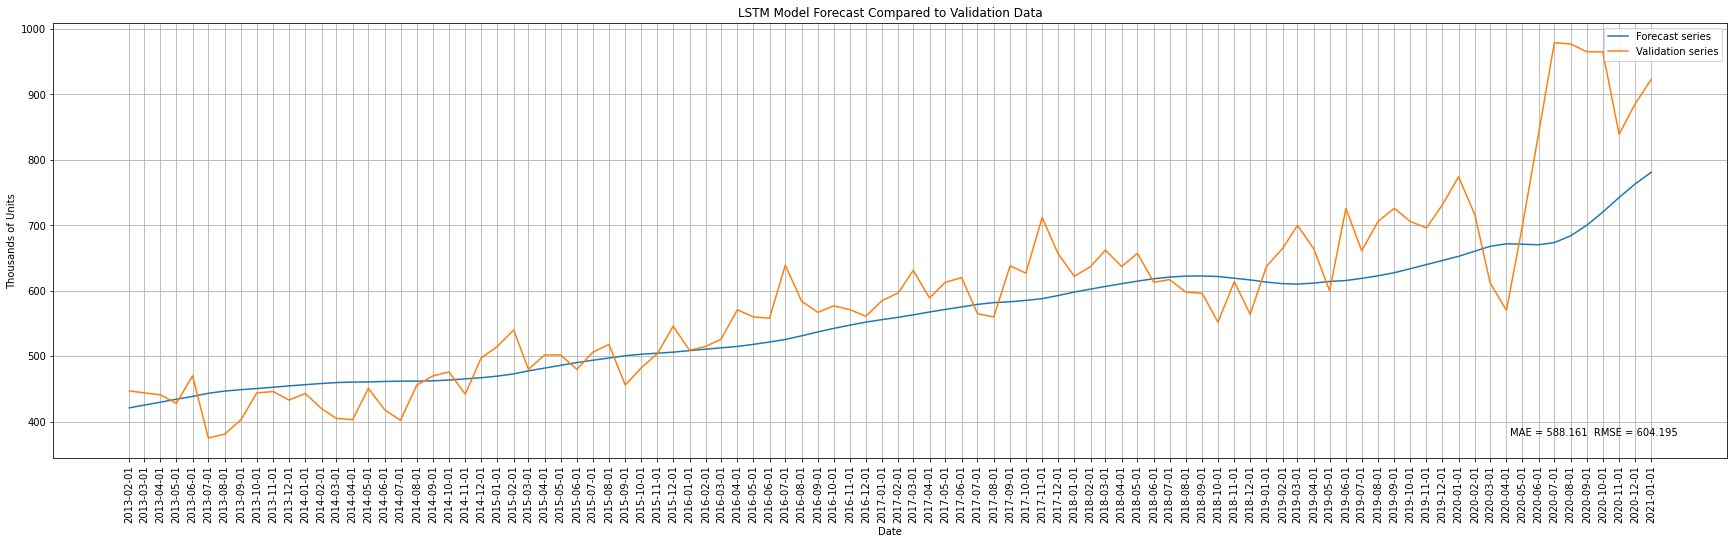

In [ ]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.show()

In [ ]:
print(textstr)

MAE = 588.161  RMSE = 604.195
